In [1]:
#%%
from confluent_kafka import Consumer, KafkaError, TopicPartition
from prometheus_client import start_http_server, Gauge, Counter
# from flaskr.trainingdata.fetch_from_API import *
from datetime import datetime, timedelta
import re
import mlflow
import gc
import csv


In [11]:

test_recommend_num = 2000
max_log_num = 1000000 #1M
counter = 0

conf = {
    'bootstrap.servers': 'localhost:9092',
    'group.id': 'mlip-team25',
    'auto.offset.reset': 'earliest',
    'enable.auto.commit': False,  # Enable auto commit
    'auto.commit.interval.ms': 1000,
}

now = datetime.now() - timedelta(days=1)
start_of_today_ = datetime(now.year, now.month, now.day)
start_of_today = start_of_today_.timestamp()

consumer = Consumer(**conf)
topic = 'movielog25'


# Find the starting offset for today
topic_partition = TopicPartition(topic, 0)  # Assuming single partition, partition ID 0
topic_partition.offset = int(start_of_today * 1000)  # Kafka expects milliseconds
offsets = consumer.offsets_for_times([topic_partition])


with open('movie_recommendations.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Timestamp', 'UserID', 'MovieID'])


with open('movie_ratings.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Timestamp', 'UserID', 'MovieID', 'Rate'])


if offsets[0].offset == -1:
    print("No messages found for the specified time range.")
else:
    # Seek to the start of the previous day
    consumer.assign([offsets[0]])
    print('Online testing...')


    try:
        while counter <= max_log_num:
            counter+=1
            msg = consumer.poll(1.0)
            if msg is None:
                continue
            if msg.error():
                if msg.error().code() == KafkaError._PARTITION_EOF:
                    # Once we reach the end of the data for the previous day, we can break out of the loop
                    print('End of partition reached or end of previous day {0}/{1}'.format(msg.topic(), msg.partition()))
                    break
                else:
                    print(msg.error())
                continue
            message_timestamp = msg.timestamp()[1]  # Get message timestamp
            message = msg.value().decode('utf-8')


            # if "GET /data/m" in message:

            #     parts1 = message.split(',')
            #     user_id = parts1[1].replace(" ","")

            #     parts2 = message.split('/')
            #     movie_id = parts2[-2].replace(" ","")
            #     minutes = parts2[-1].split('.')[0].replace(" ","")
            #     last_log_time = parts1[0]
            if "GET /rate" in message:
                rate = message[-1]
                if (rate.isdigit() == False or int(rate) < 0 or int(rate) > 5):
                    continue
                parts1 = message.split(',')
                timestamp_rate = parts1[0]
                user_id = parts1[1].replace(" ","")
                if (user_id.isdigit() == False):
                    continue
                parts2 = message.split('/')
                movie_id = parts2[2][:-2].replace(" ","")
                with open('movie_ratings.csv', 'a', newline='') as file:
                    rate_writer = csv.writer(file)
                    rate_writer.writerow([timestamp_rate, user_id, movie_id, rate])
                    # assert(False)


            if "recommendation request 17645-team25.isri.cmu.edu:8082, status 200" in message:
                # process recommendation
                match = re.search(r"result: (.*?), \d+ ms", message)
                if match:
                    movie_id = match.group(1)
                    userid = message.split(',')[1]
                    timestamp = message.split(',')[0]
                    row = [timestamp, userid, movie_id]
                    with open('movie_recommendations.csv', 'a', newline='') as file:
                        writer = csv.writer(file)
                        writer.writerow(row)
                        
                    
                else:
                    print("No match found from recommendation log.")
                    continue

    finally:
        consumer.close()


Online testing...


In [13]:
import pandas as pd
df_rating = pd.read_csv("movie_ratings.csv")
df_rating

,Timestamp,UserID,MovieID,Rate
0,2024-04-25T00:00,767801,yojimbo+1961,5
1,2024-04-25T00:00,426976,seed+2007,4
2,2024-04-25T00:00,164955,you+will+meet+a+tall+dark+stranger+2010,3
3,2024-04-25T00:00,484098,little+big+man+1970,3
4,2024-04-25T00:00,800335,porco+rosso+1992,3
...,...,...,...,...
5640,2024-04-25T00:22:25,10468,hot+coffee+2011,4
5641,2024-04-25T00:22:25,598925,aliens+1986,4
5642,2024-04-25T00:22:26,51146,hot+coffee+2011,4
5643,2024-04-25T00:22:26,558669,first+blood+1982,4


/tmp/ipykernel_2464544/4169953601.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_movies_rated, x='MovieID', y='Frequency', palette='viridis')


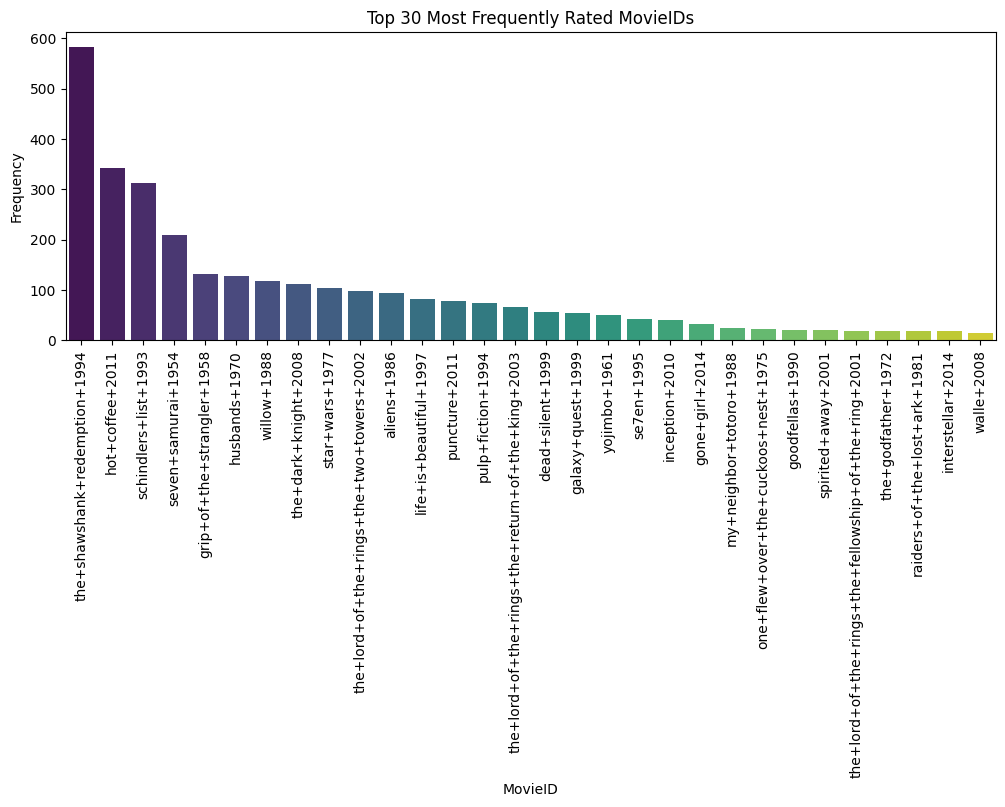

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
movie_rate_counts = df_rating['MovieID'].value_counts() 

# Create a new DataFrame for the sorted top 30 MovieIDs
top_movies = pd.DataFrame({
    'MovieID': movie_rate_counts.index,
    'Frequency': movie_rate_counts.values
})

top_movies_rated = top_movies.sort_values(by='Frequency', ascending=False).iloc[:30]

plt.figure(figsize=(12, 4))
sns.barplot(data=top_movies_rated, x='MovieID', y='Frequency', palette='viridis')
plt.title('Top 30 Most Frequently Rated MovieIDs')
plt.xlabel('MovieID')
plt.ylabel('Frequency')
plt.xticks(rotation=90) 
plt.show()

In [12]:
df_rec = pd.read_csv("movie_recommendations.csv")
df_rec

,Timestamp,UserID,MovieID
0,2024-04-25T00:00:00.260379,8743,"the+shawshank+redemption+1994, seven+samurai+1..."
1,2024-04-25T00:00:00.365693,244579,"the+shawshank+redemption+1994, schindlers+list..."
2,2024-04-25T00:00:00.375473,71649,"the+shawshank+redemption+1994, seven+samurai+1..."
3,2024-04-25T00:00:00.419491,451170,"porco+rosso+1992, hot+coffee+2011, dead+silent..."
4,2024-04-25T00:00:01.159229,439534,"life+is+beautiful+1997, hot+coffee+2011, dead+..."
...,...,...,...
7615,2024-04-25T00:22:25.149802,960672,"hot+coffee+2011, dead+silent+1999, willow+1988..."
7616,2024-04-25T00:22:25.194582,367459,"seven+samurai+1954, the+shawshank+redemption+1..."
7617,2024-04-25T00:22:25.229674,665636,"castle+in+the+sky+1986, hot+coffee+2011, dead+..."
7618,2024-04-25T00:22:25.290093,887061,"schindlers+list+1993, the+dark+knight+2008, pu..."


/tmp/ipykernel_2464544/1448721323.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_movies_rec, x='MovieID', y='Frequency', palette='viridis')


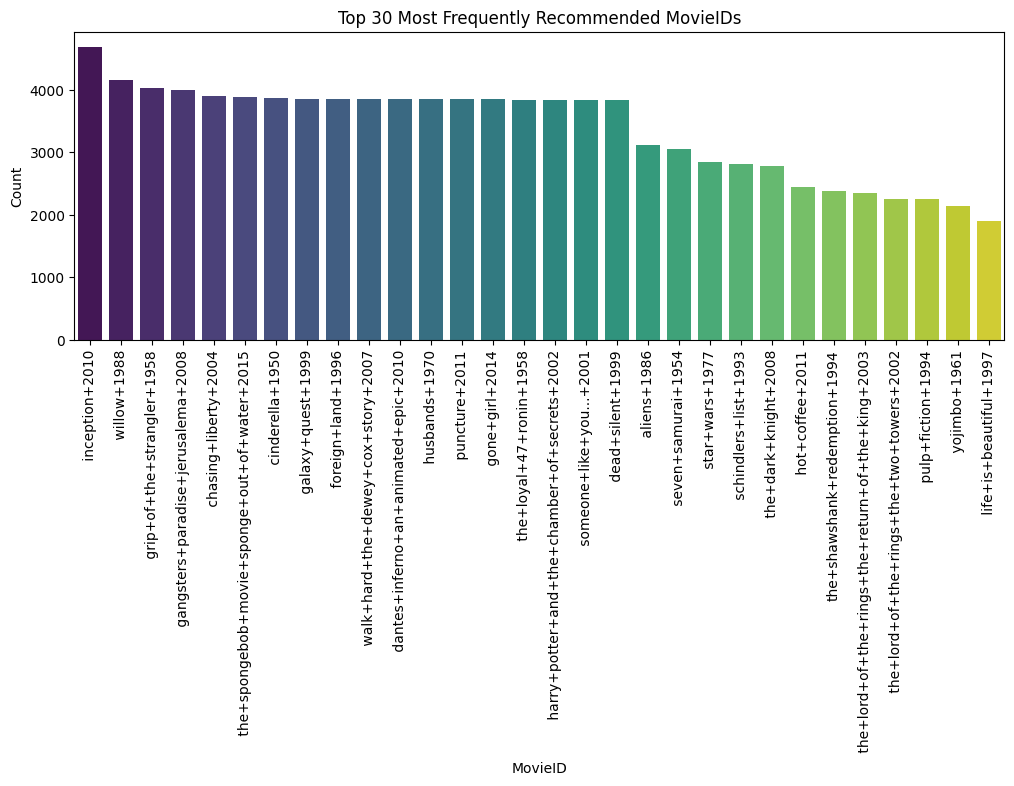

In [46]:
all_movie_ids = [movie_id for movie_list in df_rec['MovieID'] for movie_id in movie_list.split(',')]
df_all_ids = pd.DataFrame(all_movie_ids, columns=['MovieID'])

movie_rec_counts = df_all_ids['MovieID'].value_counts()

# Create a new DataFrame for the sorted top 30 MovieIDs
top_movies = pd.DataFrame({
    'MovieID': movie_rec_counts.index,
    'Frequency': movie_rec_counts.values
})

top_movies_rec = top_movies.sort_values(by='Frequency', ascending=False).iloc[:30]

plt.figure(figsize=(12, 4))
sns.barplot(data=top_movies_rec, x='MovieID', y='Frequency', palette='viridis')
plt.title('Top 30 Most Frequently Recommended MovieIDs')
plt.xlabel('MovieID')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate labels for better readability
plt.show()

In [47]:
#find correlation coefficient between these two
df_merged = pd.merge(movie_rate_counts, movie_rec_counts, on='MovieID', suffixes=('_rate', '_recommend'))
df_merged

,count_rate,count_recommend
MovieID,,
the+shawshank+redemption+1994,583,2378
hot+coffee+2011,343,1411
schindlers+list+1993,312,926
seven+samurai+1954,210,460
grip+of+the+strangler+1958,131,7
...,...,...
men_+women++children+2014,1,5
confetti+2006,1,5
the+city+of+lost+children+1995,1,1


/tmp/ipykernel_2464544/4067033189.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_merged['MovieID'], rotation=90)


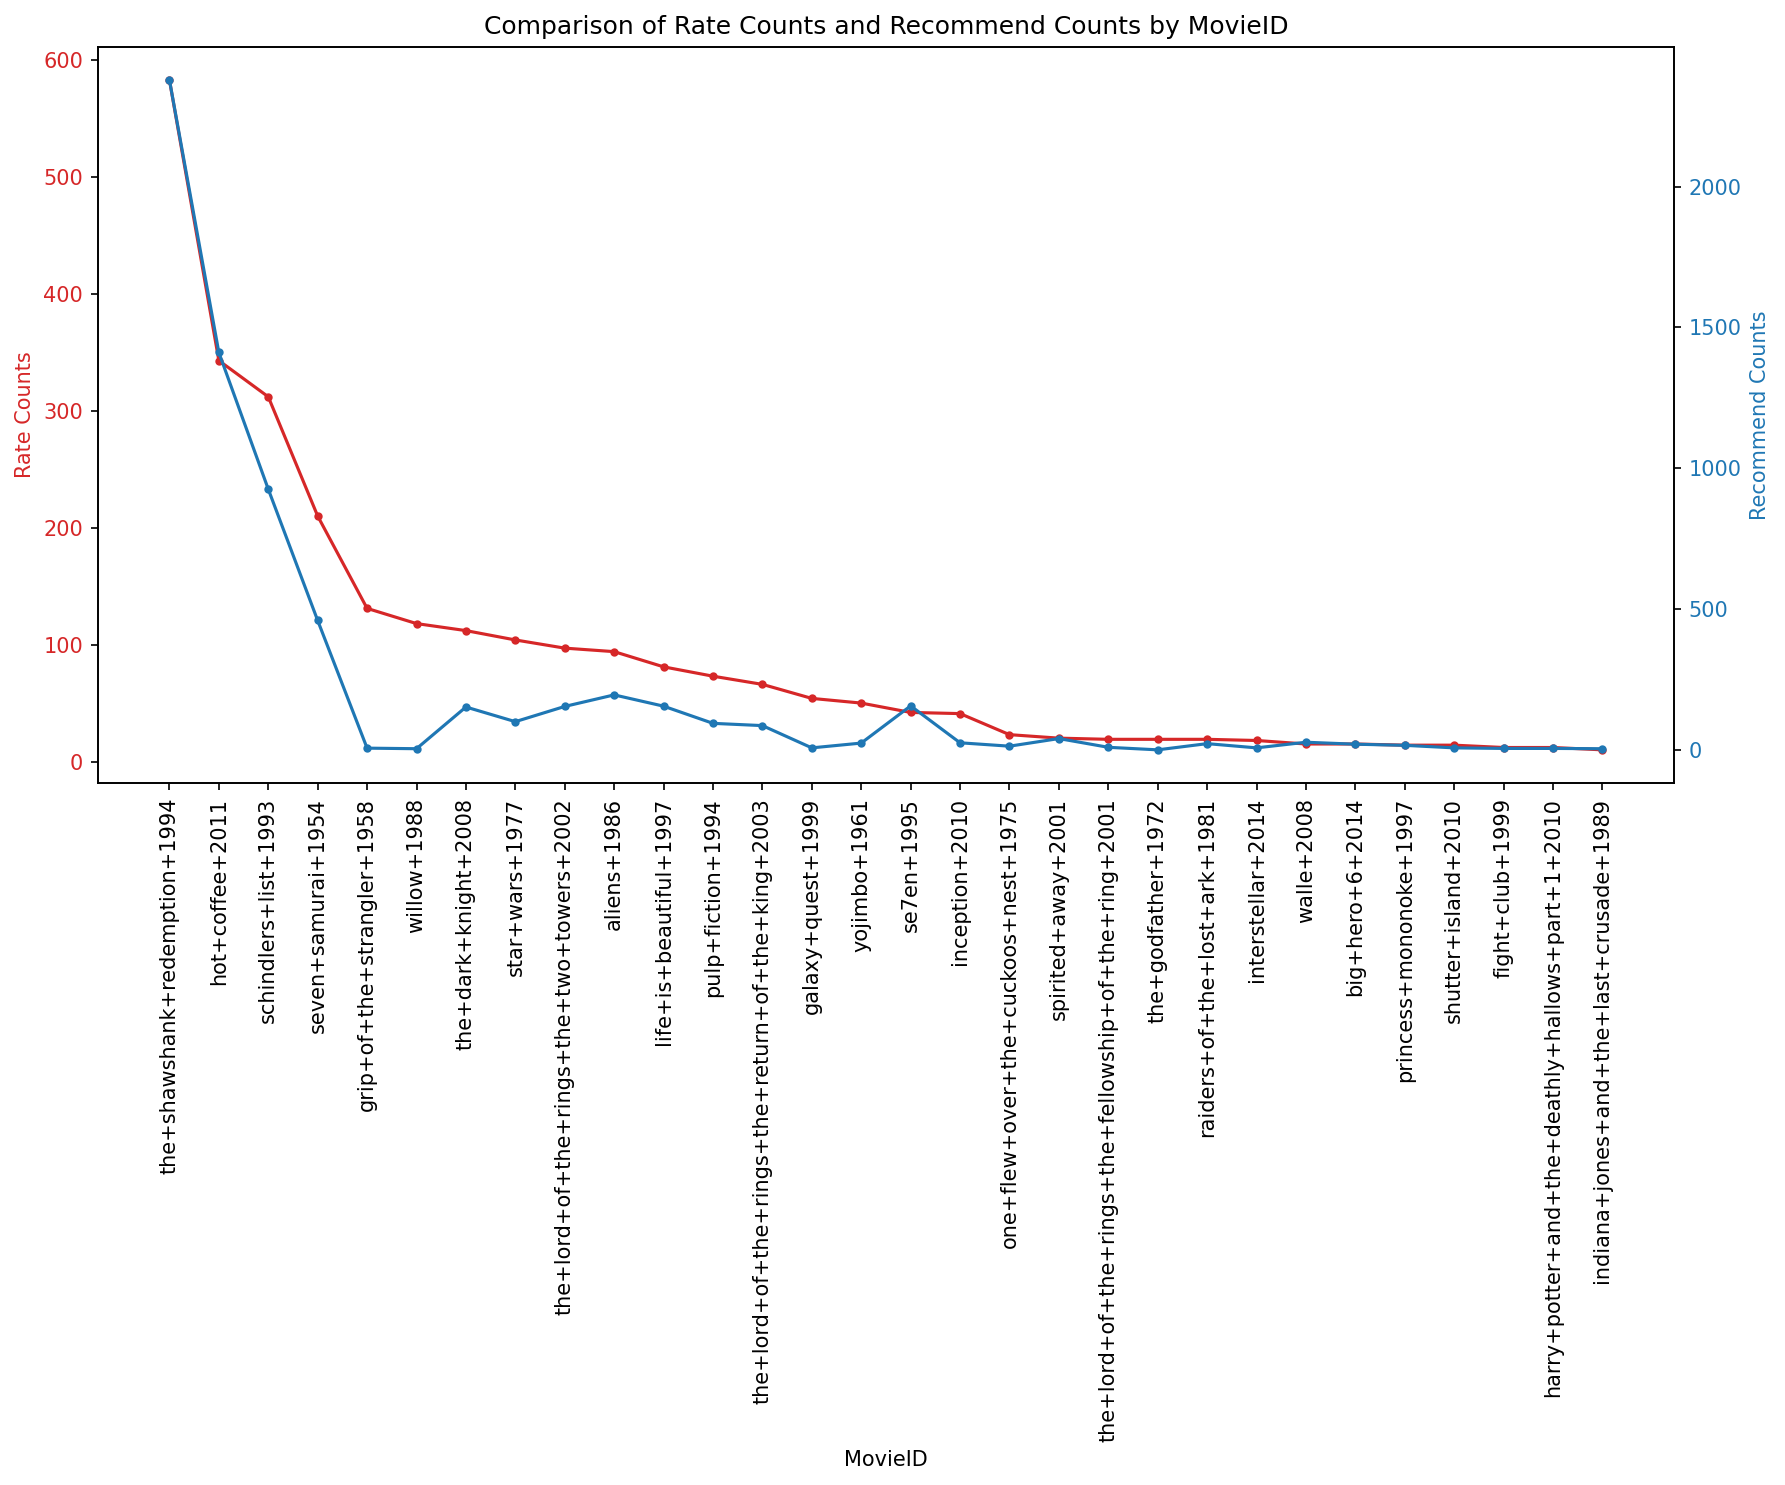

In [57]:
import matplotlib.pyplot as plt
df_merged = pd.merge(movie_rate_counts, movie_rec_counts, on='MovieID', suffixes=('_rate', '_recommend')).reset_index().iloc[:30]

fig, ax1 = plt.subplots(figsize=(12, 10), dpi=150)

color = 'tab:red'
ax1.set_xlabel('MovieID')
ax1.set_ylabel('Rate Counts', color=color)
ax1.plot(df_merged['MovieID'], df_merged['count_rate'], color=color, marker='.')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(df_merged['MovieID'], rotation=90)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Recommend Counts', color=color)  
ax2.plot(df_merged['MovieID'], df_merged['count_recommend'], color=color, marker='.')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Comparison of Rate Counts and Recommend Counts by MovieID')
fig.tight_layout() 
plt.show()


In [49]:
correlation_coefficient = df_merged['count_rate'].corr(df_merged['count_recommend'])
print("Correlation Coefficient:", correlation_coefficient)

Correlation Coefficient: 0.9453035095997545
